<a href="https://colab.research.google.com/github/SaswatD27/21cs460_group01/blob/main/Code/P2PModelMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Bootstrapping

In [ ]:
import random
import math
import time
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from copy import deepcopy
from statistics import mean


## Loading MNIST

In [ ]:
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
#emnist_train, emnist_test = datasets.emnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
img_rows, img_cols = 28, 28

11501568/11490434 [==============================] - 0s 0us/step


### Partitioning MNIST (indices) for clients

In [ ]:
K=100
n_k_dev= np.random.randint(100,600,K)
n_tot=sum(n_k_dev)
client_images=deepcopy(list(range(len(train_images))))
random.shuffle(client_images)
x_train=[]
y_train=[]

indices_dev=[]
for i in range(K):
  indices_dev.append([])
  for j in range(n_k_dev[i]):
    k=client_images.pop()
    indices_dev[i].append(k)

def no_of_pts(id):
    return n_k_dev[id]

## Defining DNN

In [ ]:

def create_DNN():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  #model.add(tf.keras.layers.Dropout(rate=0.2))
  #model.add(tf.keras.layers.BatchNormalization())
  #model.add(tf.keras.layers.Dense(units=512, activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(units=10, activation='softmax')) 
  #model.add(tf.keras.layers.BatchNormalization())
  return model

In [ ]:
server_model=create_DNN()

## Clients Setup

### Training The model

In [ ]:
def device_local_learning(ini_model,id): #Conducts local training for SGD and outputs weight vector
    model=ini_model
    model.compile(optimizer='adam',
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    history = model.fit(train_images[indices_dev[id]],train_labels[indices_dev[id]], epochs=20, validation_data=(test_images, test_labels), verbose=0)
    #print(id," done.")
    save_weight(model, n_k_dev[id], id)

In [ ]:
#Save Weights locally to used by the device
def save_weight(w,n_k,id):
    n_k_devices[id]=n_k
    fl = str(id)
    w.save_weights(fl + "_wn")

### Communication and Aggregation

In [ ]:
#Averaging for modified federated Average for DNN
def avg_weights(client_frac,client_models,n_clients_round):
  client_models=np.array(client_models)
  res=client_frac[0]*np.array(client_models[0].get_weights())
  #print(res)
  for i in range(1,n_clients_round):
    res+=client_frac[i]*np.array(client_models[i].get_weights())
  return res

In [ ]:
#FED_AVG_DNN :
def fed_avg_DNN(client_models, client_n):
  fin_model=create_DNN()
  fin_model.set_weights(0*np.array(fin_model.get_weights()))
  client_frac=np.zeros(len(client_n))
  for i in range(len(client_n)):
    client_frac[i]=(client_n[i])*(1/np.sum(client_n))
  #Set new weights as the fedrated average weight
  fin_model.set_weights(avg_weights(client_frac,client_models,len(client_frac)))
  return fin_model

In [ ]:
#Request Other device for their weights
def request_dat(initiate):
    w_n=create_DNN()
    fl = str(initiate)
    w_n.load_weights(fl + "_wn").expect_partial()
    n_k_new= n_k_devices[initiate]
    return w_n,n_k_new

In [ ]:
# Initiate communication and does the aggregation
def communicate(w_o, training_subset,n_k):
    #Take a random subset of the training subset and call them 
    comm_len= np.random.randint(1,max(len(training_subset),2))
    call_to = np.random.choice(training_subset,comm_len)
    print("Calling to",call_to)

    w_=[]
    n_=[]
    w_.append(w_o)
    n_.append(n_k)
    for i in call_to:
        w_w,n_w=request_dat(i)
        w_.append(w_w)
        n_.append(n_w)
    w_new=fed_avg_DNN(w_,n_)
    w_o.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    w_new.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    w_new.save_weights("w_new")
    err_o=1-w_o.evaluate(test_images,  test_labels, verbose=2)[1]
    err_1=1-w_new.evaluate(test_images,  test_labels, verbose=2)[1]
    #Compares old and new weights to decide which one performs better
    if err_1<err_o:
        return w_new
    else:
        return w_o

In [ ]:
#Initiate P2P learn by making a training subset which does not include the device which is calling
def p2p_learn(initiate,training_subset):
    w_n,n_k_new=request_dat(initiate)
    training_subset_c=training_subset.copy()
    training_subset_c=training_subset_c.tolist()
    training_subset_c.remove(initiate)
    w_new=communicate(w_n,training_subset_c,n_k_new)
    return w_new

In [ ]:
def P2P_new_fed1(K, C, server_model):
    # Training Subset is subset of all available devices
    training_subset = np.random.choice(all_device, int(C * K), replace=False)
    print("Training Subset",training_subset)

    # Initiate a random model
    ini_model=create_DNN()
    try:
        ini_model.load_weights("w_new")
    except:
        ini_model=server_model

    #Send the model to all the devices in the training subset
    for j in training_subset:
        device_local_learning(ini_model,j)
    print("Initial Model sent.")

    w_new=[]
    acc=[]
    #Train all the models in the training subset using P2P 
    for i in training_subset:
        w_new.append(p2p_learn(i,training_subset))

    #Testing the new models    
    for w in w_new:
      acc.append(w.evaluate(test_images,  test_labels, verbose=0)[1])
    print("Accuracies for new models via P2P are",acc,"\n Max Accuracy = ",max(acc),"\n Min Accuracy = ",min(acc),"\n Mean Accuracy = ",np.mean(acc))
    ind_acc=[i for i in range(len(acc))]
    plt.scatter(ind_acc,acc)
    plt.xlabel('Clients in Training Sample')
    plt.ylabel('Accuracy')
    plt.title('P2P Model : Accuracy of Individual Clients')
    plt.show()
    ini_model.load_weights("w_new")
    print(ini_model.evaluate(test_images,  test_labels, verbose=0)[1])

[48 46  1 89  9 42  0 55 45 51 17  7 12 57 61 67 78 79 63 24 49 97 99 16
 60]
Initial Model sent.
Calling to [60 60 55 79 89 61 42 57 97 24 57 61 17]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


313/313 - 1s - loss: 0.9833 - accuracy: 0.7673 - 653ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2513 - accuracy: 0.9274 - 655ms/epoch - 2ms/step
Calling to [79 55 78 48 51  7 48  0 99 24 78 89  7]
313/313 - 1s - loss: 0.4900 - accuracy: 0.8509 - 628ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2668 - accuracy: 0.9204 - 614ms/epoch - 2ms/step
Calling to [42 60 99]
313/313 - 1s - loss: 0.5010 - accuracy: 0.8562 - 598ms/epoch - 2ms/step
313/313 - 1s - loss: 0.3157 - accuracy: 0.9115 - 621ms/epoch - 2ms/step
Calling to [ 9 17 99 42 51 79 60 24 97  9 60]
313/313 - 1s - loss: 0.5445 - accuracy: 0.8537 - 629ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2957 - accuracy: 0.9200 - 634ms/epoch - 2ms/step
Calling to [46 49  7 97]
313/313 - 1s - loss: 0.5700 - accuracy: 0.8547 - 627ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2929 - accuracy: 0.9128 - 607ms/epoch - 2ms/step
Calling to [55 46 12 12 78  9  0 60 78 67 89 12 16 63 17  9 48 67  1 16]
313/313 - 1s - loss: 0.5067 - accuracy: 0.8721 - 642ms/epoch -

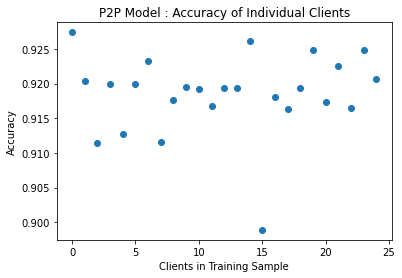

0.9205999970436096
Time taken for P2P federated learning 511.39870023727417
[367. 552.   0.   0.   0.   0.   0. 157.   0. 284.   0.   0. 451.   0.
   0.   0. 203. 144.   0.   0.   0.   0.   0.   0. 265.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 435.   0.   0. 157. 546.   0. 222. 269.   0. 191.   0.   0.   0. 406.
   0. 100.   0.   0. 273. 380.   0. 416.   0.   0.   0. 113.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 267. 543.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 418.   0.   0.   0.   0.   0.   0.   0. 337.
   0. 202.]


In [ ]:
#To run another subsequent round, simply hit run again; prior weights, if any, are saved.
K = 100
C = 0.25
B= int(K * C)
n = 20

n_k_devices=np.zeros(K)
all_device=np.arange(K)


time1 = time.time()
P2P_new_fed1(K, C, server_model)
time2 = time.time()
print("Time taken for P2P federated learning", time2 - time1)
print(n_k_devices)


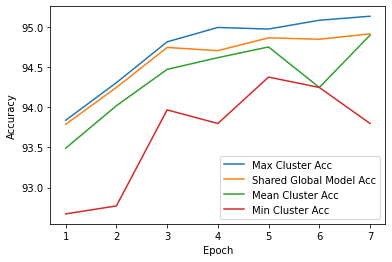

In [ ]:
#Plot Accuracy for multiple runs
max_acc=[93.83999705314636,94.30999755859375,94.8199987411499,94.9999988079071,94.98000144958496,95.09000182151794,95.13999819755554]
min_acc=[92.66999959945679,92.76999831199646,93.97000074386597,93.80000233650208,94.37999725341797,94.24999952316284,93.80000233650208]
mean_acc=[93.49119901657105,94.02160000801086,94.4760000705719,94.62239980697632,94.7564001083374,94.24999952316284,94.90360021591187]
global_acc=[93.79000067710876,94.24999952316284,94.74999904632568,94.70999836921692,94.87000107765198,94.85240006446838,94.91999745368958]
x_cords_plt=range(1,8)
plt.plot(x_cords_plt,max_acc, label='Max Cluster Acc')
plt.plot(x_cords_plt,global_acc, label='Shared Global Model Acc')
plt.plot(x_cords_plt,mean_acc, label='Mean Cluster Acc')
plt.plot(x_cords_plt,min_acc, label='Min Cluster Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')